In [39]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.utils.plotting import plot_series
from sktime.transformations.series.boxcox import LogTransformer
from sktime.utils.plotting import plot_correlations
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
import statsmodels.api as sm
from sktime.forecasting.ets import AutoETS

In [40]:
# Lectura de los datos
aapl_df = pd.read_csv("../data/aapl.csv", sep=";", decimal= ",")
# Cambio de formato a la columna fecha
aapl_df["fecha"] = pd.to_datetime(aapl_df["fecha"], format="%m/%d/%Y")
aapl_df = aapl_df.set_index("fecha")
aapl_df

,Trimeste,Ingresos
fecha,,
1989-12-29,Q1 1990,1493.4
1990-03-30,Q2 1990,1346.2
1990-06-29,Q3 1990,1364.8
1990-09-28,Q4 1990,1354.1
1990-12-28,Q1 1991,1675.5
...,...,...
2020-06-27,Q3 2020,59685.0
2020-09-26,Q4 2020,64698.0
2020-12-26,Q1 2021,111439.0


In [41]:
# Resampleamos por trimestres
aapl_ts = aapl_df.resample("Q").last().drop("Trimeste", 1)

aapl_ts_q = aapl_df['Ingresos'].astype('float64').to_period('Q').sort_index()
aapl_ts_q

fecha
1989Q4      1493.4
1990Q1      1346.2
1990Q2      1364.8
1990Q3      1354.1
1990Q4      1675.5
            ...   
2020Q2     59685.0
2020Q3     64698.0
2020Q4    111439.0
2021Q1     89584.0
2021Q2     81434.0
Freq: Q-DEC, Name: Ingresos, Length: 127, dtype: float64

In [42]:
# Transformación logarítmica de la serie
transformer = LogTransformer()
log_aapl_ts = transformer.fit_transform(aapl_ts_q)

Text(0.5, 1.0, 'Ingresos Apple: Transformación LOG (Figura 4)')

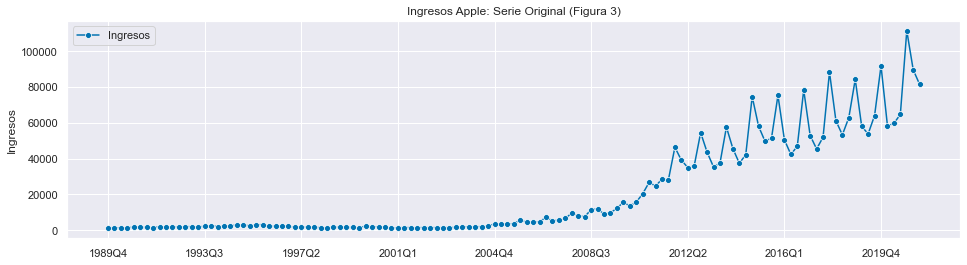

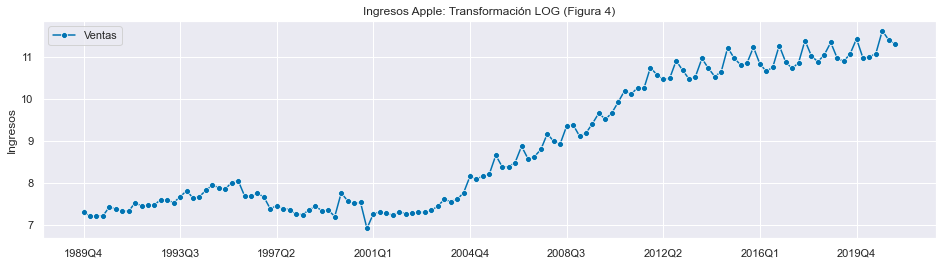

In [43]:
# Plot Log Data & Original Data
fig, ax =plot_series(aapl_ts_q, labels=["Ingresos"])
ax.set_title('Ingresos Apple: Serie Original (Figura 3)')
fig, ax =plot_series(log_aapl_ts, labels=["Ventas"])
ax.set_title('Ingresos Apple: Transformación LOG (Figura 4)')

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Ingresos'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

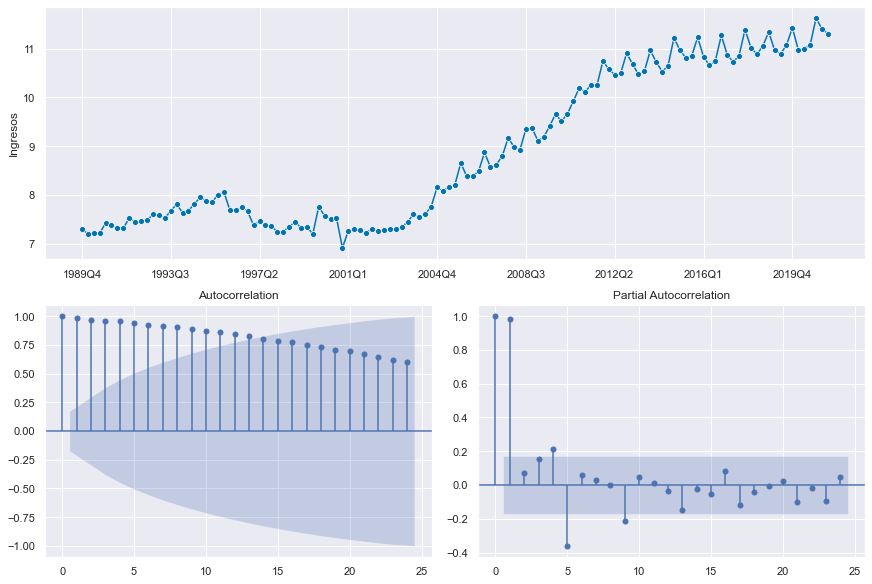

In [44]:
# Autocorrelación de la serie temporal
plot_correlations(log_aapl_ts)

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Ingresos'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

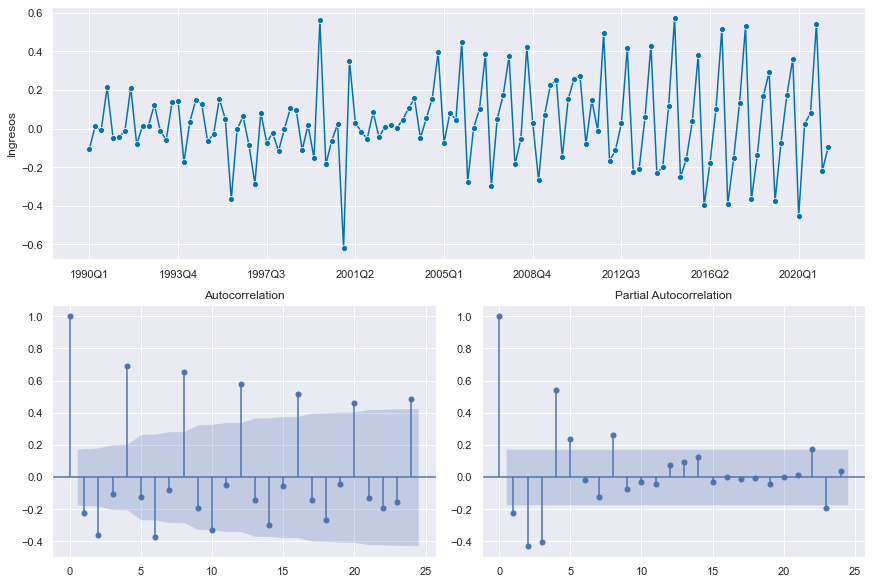

In [45]:
x = 1
transf_diff= Differencer(lags=x)
plot_correlations(transf_diff.fit_transform(log_aapl_ts))

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Ingresos'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

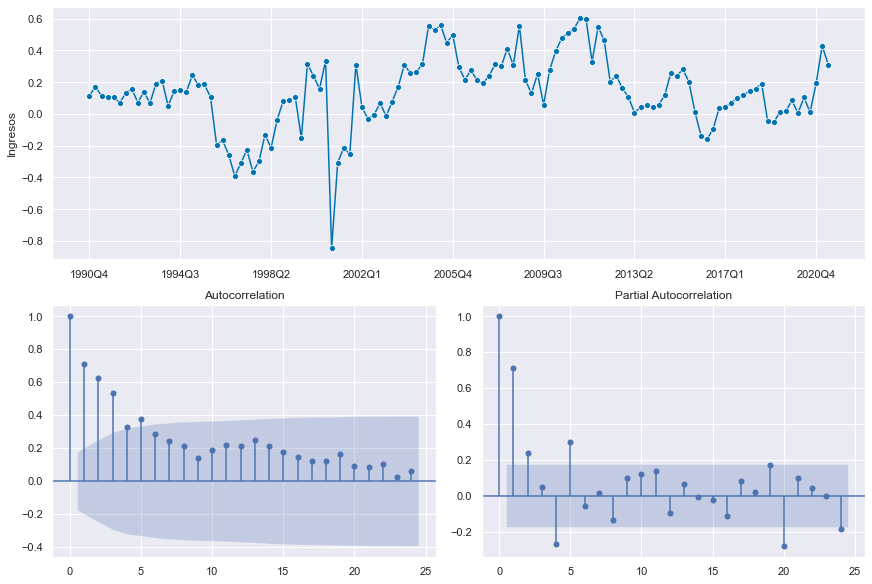

In [46]:
x = 4
transf_diff= Differencer(lags=x)
plot_correlations(transf_diff.fit_transform(log_aapl_ts))

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Ingresos'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

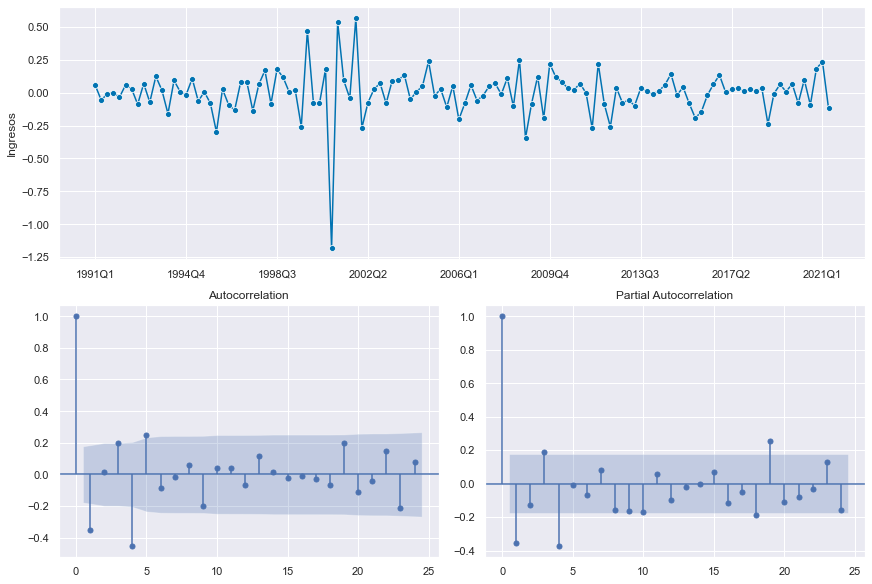

In [47]:
x = [1,4]
transf_diff= Differencer(lags=x)
plot_correlations(transf_diff.fit_transform(log_aapl_ts))

Text(0.5, 1.0, 'Comportamiento Estacional')

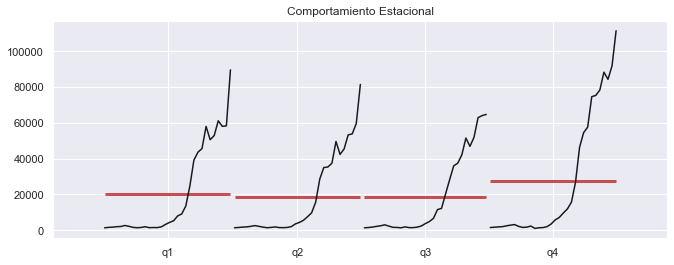

In [48]:
sns.set(rc={'figure.figsize':(11, 4)})
ax = plt.gca()
sm.graphics.tsa.quarter_plot(aapl_ts['Ingresos'],ax=ax)
ax.set_title('Comportamiento Estacional')

119 8


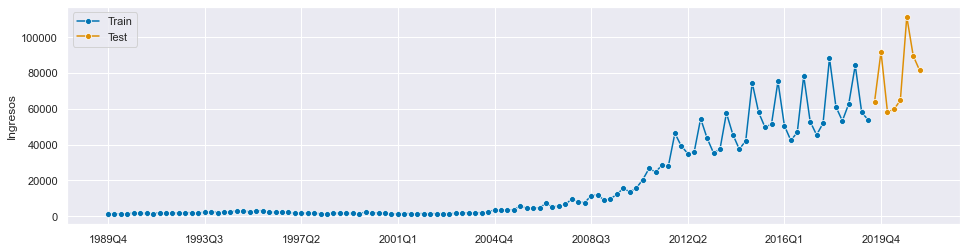

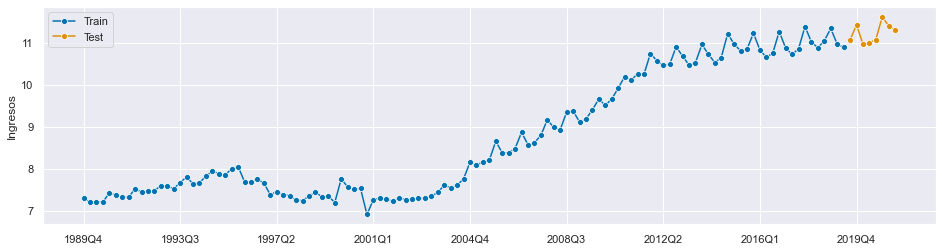

In [49]:
# MODELOS ARIMA

# Separamos el data set en training y testing sets. Este último, de 8 trimestres.

y_train, y_test = temporal_train_test_split(y = aapl_ts_q, test_size = 8)
log_y_train, log_y_test = temporal_train_test_split(y = log_aapl_ts, test_size = 8)
plot_series(y_train, y_test, labels=["Train", "Test"])
plot_series(log_y_train, log_y_test, labels=["Train", "Test"])
print(y_train.shape[0], y_test.shape[0])

In [50]:
# Horizonte de predicción
fh = np.arange(1, 9)

In [51]:
# Función Auto ARIMA
forecaster = AutoARIMA(sp=4, suppress_warnings=True)
forecaster.fit(log_y_train)
print(forecaster.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  119
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 4)   Log Likelihood                  58.925
Date:                             Mon, 01 Nov 2021   AIC                           -107.851
Time:                                     20:12:53   BIC                            -93.997
Sample:                                          0   HQIC                          -102.226
                                             - 119                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3380      0.086     -3.935      0.000      -0.506      -0.170
ar.L2         -0.1676      

In [52]:
log_y_pred = forecaster.predict(fh)
y_pred = np.exp(log_y_pred)

In [53]:
# Mean Absolute Percentage Erro
error_log_pred = mean_absolute_percentage_error(log_y_test, log_y_pred)
error_pred = mean_absolute_percentage_error(y_test, y_pred)
error_squared_pred = MeanSquaredError(square_root=True)(y_test, y_pred)
print("El error medio absoluto de las predicciones logarítmicas es de " + str(round(error_log_pred*100, 3)) + " %" )
print("El error medio absoluto de las predicciones absolutas es de " + str(round(error_pred*100, 3)) + " %")
print("El error medio de los cuadrados es de " + str(round(error_squared_pred, 3)))

El error medio absoluto de las predicciones logarítmicas es de 1.432 %
El error medio absoluto de las predicciones absolutas es de 15.975 %
El error medio de los cuadrados es de 16226.199


In [54]:
# Efecto COVID
covid_effect = pd.Series(y_pred.loc["2020"].values - aapl_ts.loc["2020"].squeeze().values).sum()
print(covid_effect)

-30874.992553701377


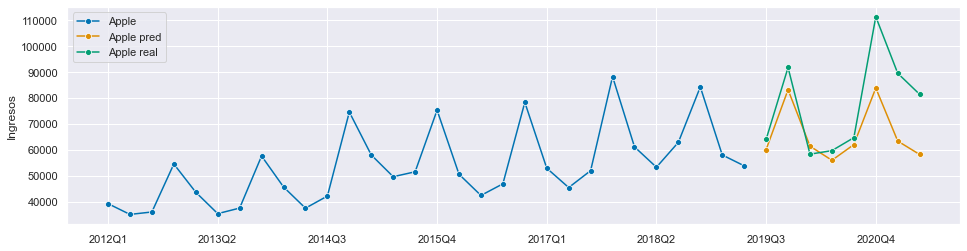

In [55]:
# Accuracy Plot
plot_series(y_train["2012":], y_pred, y_test, labels=["Apple", "Apple pred", "Apple real"])
plt.savefig('../img/predict-AutoARIMA.png')

In [56]:
# Forecast Horizon
fh = np.arange(6) + 1

In [57]:
# Auto ARIMA
forecaster = AutoARIMA(sp=4, suppress_warnings=True)
forecaster.fit(log_aapl_ts)

AutoARIMA(sp=4, suppress_warnings=True)

In [58]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  127
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 4)   Log Likelihood                  65.871
Date:                           Mon, 01 Nov 2021   AIC                           -117.742
Time:                                   20:13:10   BIC                            -97.888
Sample:                                        0   HQIC                          -109.676
                                           - 127                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0810      0.226     -4.785      0.000      -1.524      -0.638
ar.L2         -0.3711      0.098     -3.806      0.000      -0.562      -0.180
ma.L1          0.7716      0.242      3.182      0.001       0.296       1.247
ar.S.L4        1.3557      0.132     10.310      0.000       1.098       1.613
ar.S.L8       -0.3649      0.125     -2.910      0.004      -0.611      -0.119
ma.S.L4       -0.8172      0.119     -6.866      0.000      -1.050      -0.584
sigma2         0.0196      0.002     11.339      0.000       0.016       0.023
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               764.19
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.11   Skew:                            -1.75
Prob(H) (two-sided):                  0.74   Kurtosis:                        14.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
# Auto ARIMA Forecast
log_y_pred = forecaster.predict(fh)
y_pred = np.exp(log_y_pred)

In [60]:
print(log_y_pred)

2021Q3    11.441461
2021Q4    11.878215
2022Q1    11.631148
2022Q2    11.549853
2022Q3    11.667013
2022Q4    12.077564
Freq: Q-DEC, dtype: float64


In [61]:
print(y_pred)

2021Q3     93102.925530
2021Q4    144093.136755
2022Q1    112549.492553
2022Q2    103761.787737
2022Q3    116659.331055
2022Q4    175881.128869
Freq: Q-DEC, dtype: float64


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

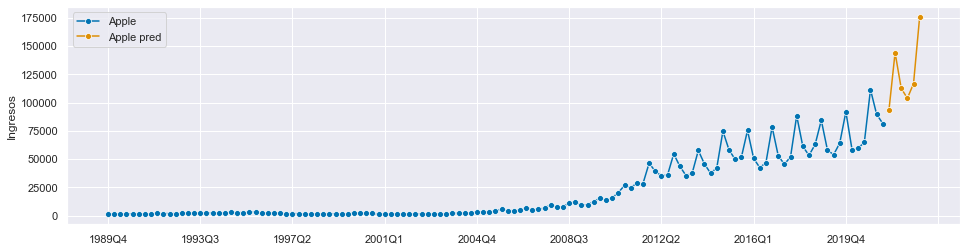

In [62]:
# Forecast Accuracy Plot
plot_series(aapl_ts_q, y_pred, labels=["Apple", "Apple pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

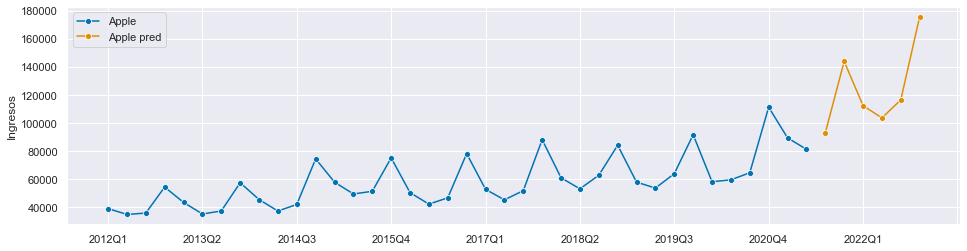

In [63]:
plot_series(aapl_ts_q["2012":], y_pred, labels=["Apple", "Apple pred"])

In [64]:
suma_pred_arima = y_pred.asfreq('Q-OCT').resample('A-OCT').sum()
suma_aapl = aapl_ts_q.squeeze().asfreq('Q-OCT').resample('A-OCT').sum()
ingresos_2022_arima = suma_pred_arima["2022"]
ingresos_2021_arima = suma_pred_arima["2021"] + suma_aapl["2021"]

print("2021: ",str(round(ingresos_2021_arima, 3)))
print("2022: " , round(ingresos_2022_arima, 3))

2021:  375559.926
2022:  477063.748


In [65]:
# MODELO ETS

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

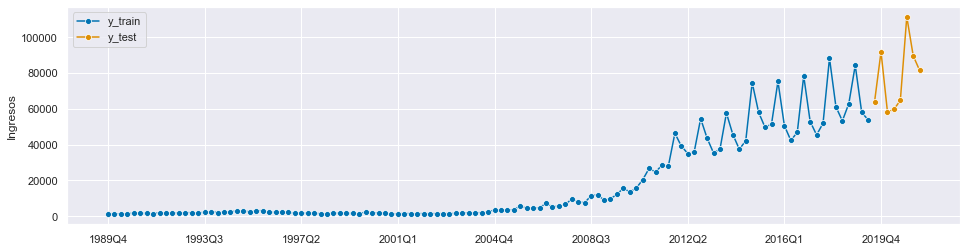

In [66]:
y_train, y_test = temporal_train_test_split(y = aapl_ts['Ingresos'].astype('float64').to_period('Q'), test_size=8)
plot_series(y_train, y_test, labels=['y_train','y_test'])

In [68]:
fh = np.arange(1, len(y_test) + 1)
aapl_auto_model = AutoETS(auto=True, sp=4, n_jobs=-1)
aapl_auto_model.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=4)

In [69]:
print(aapl_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood                -968.025
Date:                Mon, 01 Nov 2021   AIC                           1956.050
Time:                        20:13:14   BIC                           1983.841
Sample:                    12-31-1989   HQIC                          1967.335
                         - 06-30-2019   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4225      0.055      7.739      0.000       0.316       0.530
smoothing_trend        0.1685      0.034      4.890      0.000       0.101       0.236
smoothing_seasonal  

In [70]:
aapl_pred = aapl_auto_model.predict(fh)
print(aapl_pred)

2019Q3    58581.324260
2019Q4    85963.036961
2020Q1    59751.794007
2020Q2    53079.519507
2020Q3    58323.456756
2020Q4    85584.221783
2021Q1    59488.194079
2021Q2    52845.096319
Freq: Q-DEC, dtype: float64


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

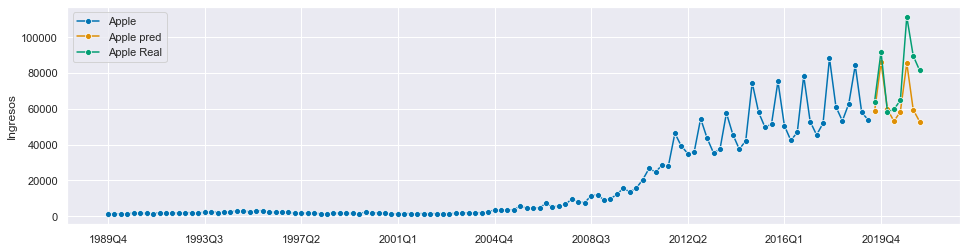

In [71]:
plot_series(y_train, aapl_pred, y_test, labels=['Apple', 'Apple pred', 'Apple Real'])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

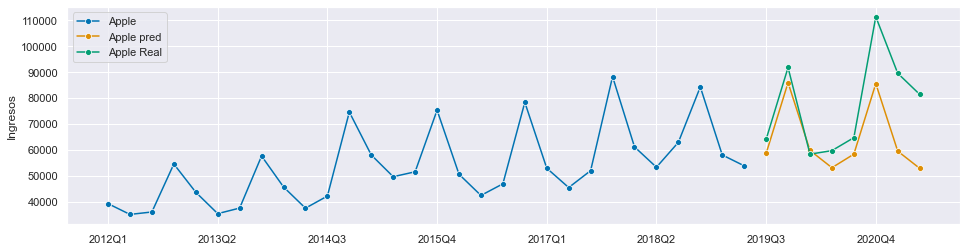

In [72]:
plot_series(y_train["2012":], aapl_pred, y_test, labels=['Apple', 'Apple pred', 'Apple Real'])

In [73]:
# Mean Absolute Percentage Error
error_pred = mean_absolute_percentage_error(y_test, aapl_pred)
error_squared_pred = MeanSquaredError(square_root=True)(y_test, aapl_pred)
print("El error medio absoluto de las predicciones absolutas es de " + str(round(error_pred, 3)))
print("El error medio de los cuadrados es de " + str(round(error_squared_pred, 0)))

El error medio absoluto de las predicciones absolutas es de 0.187
El error medio de los cuadrados es de 17825.0


In [95]:
# Efecto COVID
covid_effect_ets = pd.Series(aapl_pred.loc["2020"].values - aapl_ts.loc["2020"].squeeze().values).sum()
print(covid_effect_ets)

-37396.007947260696


In [74]:
# Predicción de los siguientes 6 trimestres
aapl_auto_model.fit(aapl_ts_q)
print(aapl_auto_model.summary())

                                 ETS Results                                  
Dep. Variable:               Ingresos   No. Observations:                  127
Model:                       ETS(MAM)   Log Likelihood               -1052.310
Date:                Mon, 01 Nov 2021   AIC                           2124.620
Time:                        20:13:15   BIC                           2153.062
Sample:                    12-31-1989   HQIC                          2136.176
                         - 06-30-2021   Scale                            0.018
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4303      0.055      7.816      0.000       0.322       0.538
smoothing_trend        0.1718      0.035      4.969      0.000       0.104       0.240
smoothing_seasonal  

In [75]:
fh = np.arange(1, 7)
aapl_pred_ets = aapl_auto_model.predict(fh)
print(aapl_pred_ets)

2021Q3     94928.191756
2021Q4    153907.744786
2022Q1    112068.402469
2022Q2    104446.054077
2022Q3    120404.555385
2022Q4    192615.690038
Freq: Q-DEC, dtype: float64


In [76]:
suma_pred_ets = aapl_pred_ets.asfreq('Q-OCT').resample('A-OCT').sum()
suma_aapl = aapl_ts_q.squeeze().asfreq('Q-OCT').resample('A-OCT').sum()
ingresos_2022_ets = suma_pred_ets["2022"]
ingresos_2021_ets = suma_pred_ets["2021"] + suma_aapl["2021"]

print("2021: ",str(round(ingresos_2021_ets, 3)))
print("2022: " , round(ingresos_2022_ets, 3))

2021:  377385.192
2022:  490826.757


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

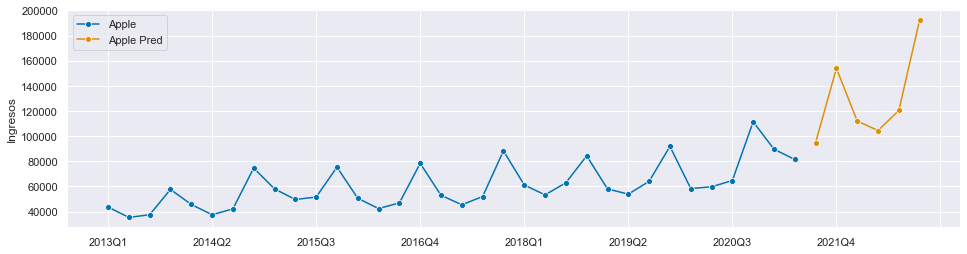

In [80]:
plot_series(aapl_ts_q["2013":], aapl_pred_ets, labels=["Apple", "Apple Pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

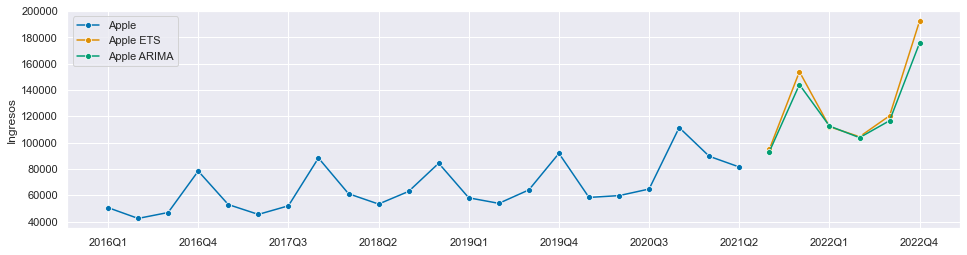

In [81]:
plot_series(aapl_ts_q["2016":], aapl_pred_ets, y_pred, labels=["Apple", "Apple ETS", "Apple ARIMA"])

In [94]:
# Ventas Anuales
ventas_anuales = aapl_df['Ingresos'].astype('float64').to_period('Y').sort_index()
ventas_anuales_variacion =(ventas_anuales.pct_change().mul(100))
print(ventas_anuales_variacion)

fecha
1989          NaN
1990    -9.856703
1990     1.381667
1990    -0.783998
1990    23.735322
          ...    
2020     2.352820
2020     8.399095
2020    72.244892
2021   -19.611626
2021    -9.097607
Freq: A-DEC, Name: Ingresos, Length: 127, dtype: float64
